In [1]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
sns.set()

## Data Processing

In [3]:
# data paths
data_dir = os.path.join(os.getcwd(), 'home-credit-default-risk')
test_path = os.path.join(data_dir, 'application_test.csv')
train_path = os.path.join(data_dir, 'application_train.csv')

In [4]:
# load DataFrames
df_train = pd.read_csv(train_path)
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_train.shape

(307511, 122)

In [6]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [7]:
df_train['TARGET'].mean()

0.08072881945686496

A `1` in the `TARGET` column indicates that the client defaulted

In [8]:
# replace {Y, N} with {1, 0}
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        df_train[column] = df_train[column].replace({'Y': 1, 'N': 0})

In [9]:
# split numerical and categorical data
numerical_cols = df_train.select_dtypes(include=['number']).columns
categorical_cols = df_train.select_dtypes(exclude=['number']).columns

# impute missing values based on mean
num_imp = SimpleImputer(strategy='mean')
num_data_imp = num_imp.fit_transform(df_train[numerical_cols])
num_df = pd.DataFrame(num_data_imp, columns=numerical_cols)

# impute missing values based on most frequent
cat_imp = SimpleImputer(strategy='most_frequent')
cat_data_imp = cat_imp.fit_transform(df_train[categorical_cols])
cat_df = pd.DataFrame(cat_data_imp, columns=categorical_cols)

# concatenate back into complete dataframe
df_train_clean = pd.concat([num_df, cat_df], axis=1)

C:\Users\brady\AppData\Local\Temp\ipykernel_14552\3789349187.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs_corrs = df_train_clean.corr()['TARGET'].abs().sort_values(ascending=False)[1:11]
C:\Users\brady\AppData\Local\Temp\ipykernel_14552\3789349187.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  top_corrs = df_train_clean.corr()['TARGET'].loc[abs_corrs.index]


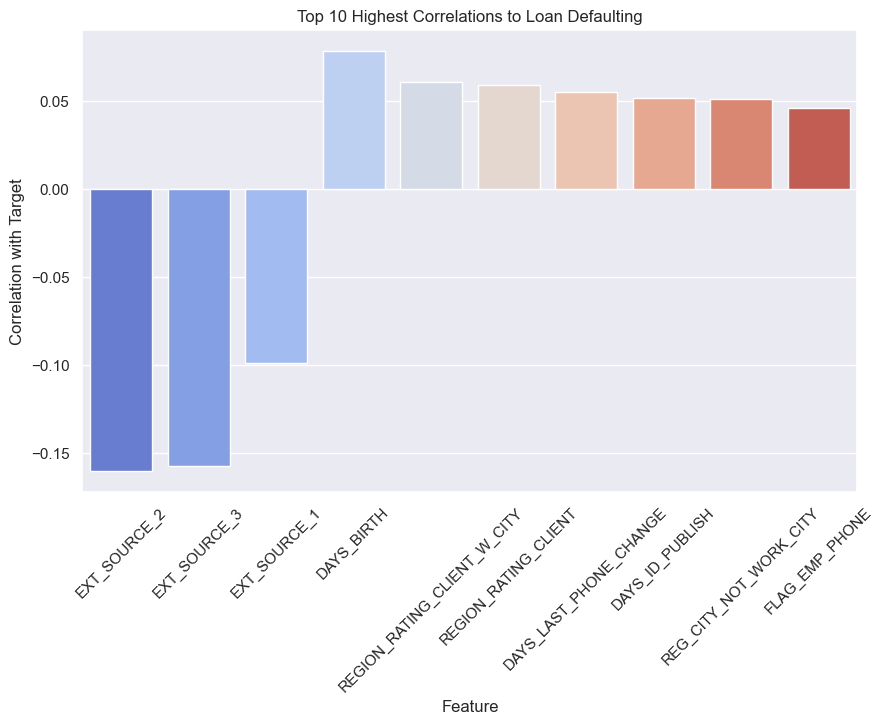

In [10]:
# choose the top 10 highest correlation columns (positive or negative)
abs_corrs = df_train_clean.corr()['TARGET'].abs().sort_values(ascending=False)[1:11]
top_corrs = df_train_clean.corr()['TARGET'].loc[abs_corrs.index]

# plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corrs.index, y=top_corrs.values, palette="coolwarm")
plt.title("Top 10 Highest Correlations to Loan Defaulting")
plt.xlabel("Feature")
plt.ylabel("Correlation with Target")
plt.xticks(rotation=45)
plt.show()

`EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3` are credit scores from external sources

## Find the Best Model

In [11]:
# find the columns that have the strongest correlations
cols = list(top_corrs.index)

# filter out only the strongest correlation columns and target
X = df_train_clean[cols]
y = df_train_clean['TARGET']

In [12]:
# split into training and validation set to find best performing model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [13]:
# create and fit Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# find training and validation accuracy scores
print(f'Training Accuracy: {rf_clf.score(X_train, y_train):.4f}')
print(f'Test Accuracy: {rf_clf.score(X_test, y_test):.4f}')

Training Accuracy: 1.0000
Test Accuracy: 0.9195


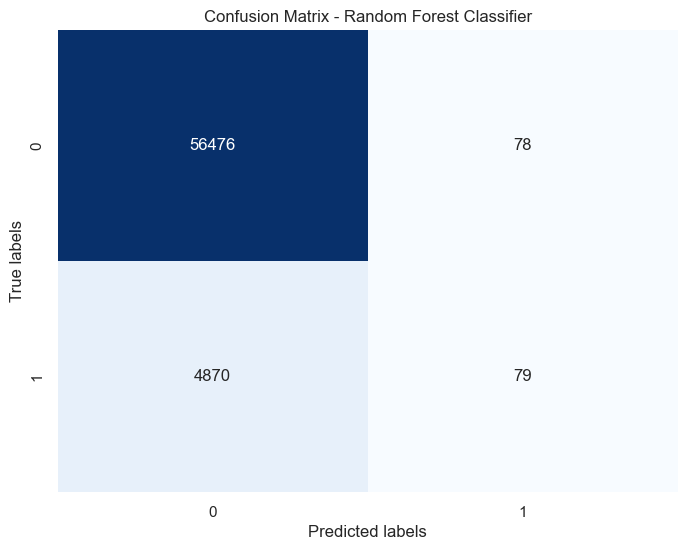

In [14]:
# y prediction values
y_pred_rf=(rf_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

### Gradient Boosting

In [15]:
# create and fit GB classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# find training and validation accuracy scores
print(f'Training Accuracy: {gb_clf.score(X_train, y_train):.4f}')
print(f'Test Accuracy: {gb_clf.score(X_test, y_test):.4f}')

Training Accuracy: 0.9196
Test Accuracy: 0.9198


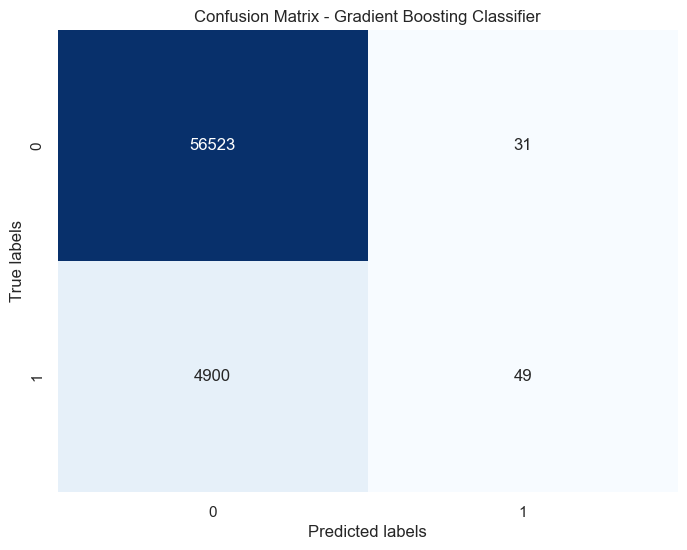

In [16]:
# y prediction values
y_pred_gb=(gb_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.show()

### Extreme Gradient Boosting

In [17]:
# create and fit XGB classifier
xgb_clf = XGBClassifier(random_state=42, max_depth=3, learning_rate=.1)
xgb_clf.fit(X_train, y_train)

# find training and validation accuracy scores
print(f'Training Accuracy: {xgb_clf.score(X_train, y_train):.4f}')
print(f'Test Accuracy: {xgb_clf.score(X_test, y_test):.4f}')

Training Accuracy: 0.9193
Test Accuracy: 0.9196


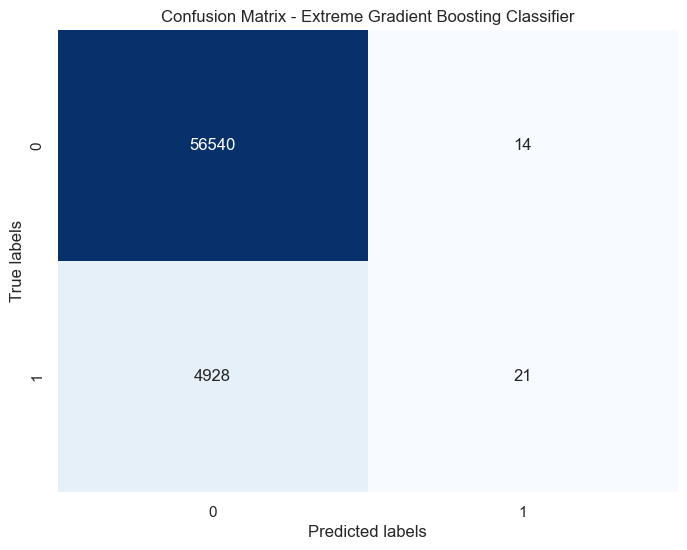

In [18]:
# y prediction values
y_pred_xgb=(xgb_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Extreme Gradient Boosting Classifier")
plt.show()

## Choosing a Model

Based on the extremely similar scores coming from each of the Ensemble Methods models, we decided to choose the Random Forest Classifier as the model that would best predict whether a client would default or not. This is because out of all of the classifiers, it had the fewest number of false negatives (Predicted the client would not default, but they did). We chose this due to the nature of the problem. Predicting a client is reliable and approving them when they actually aren't has far worse implications than falsely rejecting an application. 

## Predicting

### Pre-Processing

In [19]:
df_test = pd.read_csv(test_path)

In [20]:
# replace {Y, N} with {1, 0}
for column in df_test.columns:
    if df_test[column].dtype == 'object':
        df_test[column] = df_test[column].replace({'Y': 1, 'N': 0})

In [21]:
# split numerical and categorical data
numerical_cols = df_test.select_dtypes(include=['number']).columns
categorical_cols = df_test.select_dtypes(exclude=['number']).columns

# impute missing values based on mean
num_imp = SimpleImputer(strategy='mean')
num_data_imp = num_imp.fit_transform(df_test[numerical_cols])
num_df = pd.DataFrame(num_data_imp, columns=numerical_cols)

# impute missing values based on most frequent
cat_imp = SimpleImputer(strategy='most_frequent')
cat_data_imp = cat_imp.fit_transform(df_test[categorical_cols])
cat_df = pd.DataFrame(cat_data_imp, columns=categorical_cols)

# concatenate back into complete dataframe
df_test_clean = pd.concat([num_df, cat_df], axis=1)

In [22]:
# train new classifier on the entire training dataset
test_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
test_clf.fit(X, y)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

`X` and `y` are the cleaned training dataframe filtered for only the strongest correlation columns.

In [23]:
# filter out only the strongest correlation columns
X_test_pred = df_test_clean[cols]

In [24]:
# predict on the test data
y_pred_test=(test_clf.predict(X_test_pred))

In [25]:
# find the 1 predicted values
y_pred_true = y_pred_test[y_pred_test == 1]

# find the percentage of predicted 1s
pred_percentage = (len(y_pred_true) / len(y_pred_test)) * 100

In [26]:
# find the 1 true values
y_true = y[y == 1]

# find the percentage of true 1s
true_percentage = (len(y_true) / len(y)) * 100

In [27]:
print(f'Actual Percentage: {true_percentage}')
print(f'Predicted Percentage: {pred_percentage}')

Actual Percentage: 8.072881945686495
Predicted Percentage: 0.17643197111439357


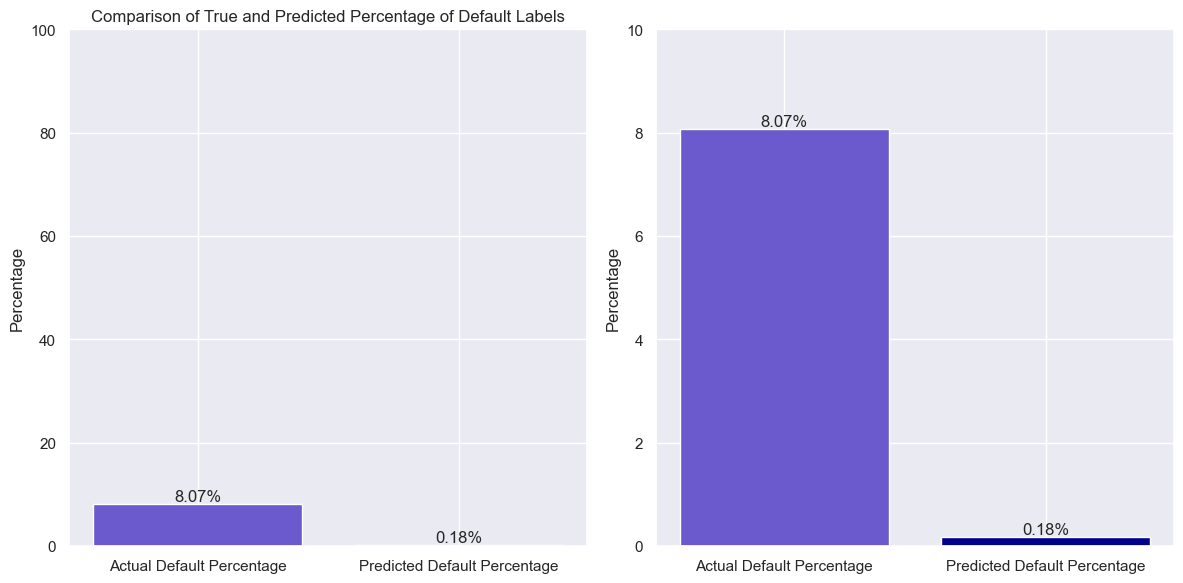

In [28]:
labels = ['Actual Default Percentage', 'Predicted Default Percentage']
values = [true_percentage, pred_percentage]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
colors = ['slateblue', 'darkblue']

# plot first subplot with percentage range 0-100
axs[0].bar(labels, values, color=colors)
for bar, value in zip(axs[0].patches, values):
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}%', ha='center', va='bottom')
axs[0].set_ylabel('Percentage')
axs[0].set_title('Comparison of True and Predicted Percentages of Positive Labels (1s)')
axs[0].set_ylim(0, 100)

# plot second  subplot with percentage range 0-10
axs[1].bar(labels, values, color=colors)
for bar, value in zip(axs[1].patches, values):
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}%', ha='center', va='bottom')
axs[1].set_ylabel('Percentage')
axs[0].set_title('Comparison of True and Predicted Percentage of Default Labels')
axs[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

This is a very interesting relationship. It appears the models are trained to prioritize avoiding false negatives over false positives for the sake of accuracy. However, in this situation, it would be beneficial to predict a higher number of true positives

In [29]:
print(f'Precision (training data, test set): {precision_score(y_test, y_pred_rf)}')
print(f'Recall (training data, test set): {recall_score(y_test, y_pred_rf)}')
print(f'F1 Score (training data, test set): {f1_score(y_test, y_pred_rf)}')

Precision (training data, test set): 0.5031847133757962
Recall (training data, test set): 0.015962820771873106
F1 Score (training data, test set): 0.0309439874657266


These suspicions were confirmed with the shockingly low precision, recall, and F1 scores of the training data

### Threshold Testing

In order to avoid a high accuracy, low effectiveness model, we next experimented with thresholds. We tested each threshold from .05 to .4 and found which one would return the least false positives while also maintaining high accuracy.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

thresholds = np.arange(0.05, 0.45, 0.05)
confusion_matrices = []
accuracies = []
recalls = []
precisions = []
f1s = []
tps = []
fps = []
tns = []
fns = []

In [31]:
# loop through each threshold
for threshold in thresholds:
    # initialize and train the RandomForestClassifier
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)
    
    # predict probabilities and compare to threshold
    y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
    y_pred_adjusted = (y_pred_prob > threshold).astype(int)
    
    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    confusion_matrices.append(conf_matrix)
    
    # fetch all values from confusion matrix
    tp = conf_matrix[1, 1]
    fp = conf_matrix[0, 1]
    tn = conf_matrix[0, 0]
    fn = conf_matrix[1, 0]
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    
    # calculate and append scores
    acc = accuracy_score(y_test, y_pred_adjusted)
    accuracies.append(acc)
    rec = recall_score(y_test, y_pred_adjusted)
    recalls.append(rec)
    prec = precision_score(y_test, y_pred_adjusted)
    precisions.append(prec)
    f1 = f1_score(y_test, y_pred_adjusted)
    f1s.append(f1)

# store results in DF
results_df = pd.DataFrame({
    'threshold': thresholds,
    'confusion_matrix': confusion_matrices,
    'accuracy': accuracies,
    'recall': recalls,
    'precision': precisions,
    'F1': f1s,
    'TP': tps,
    'FP': fps,
    'TN': tns,
    'FN': fns
})

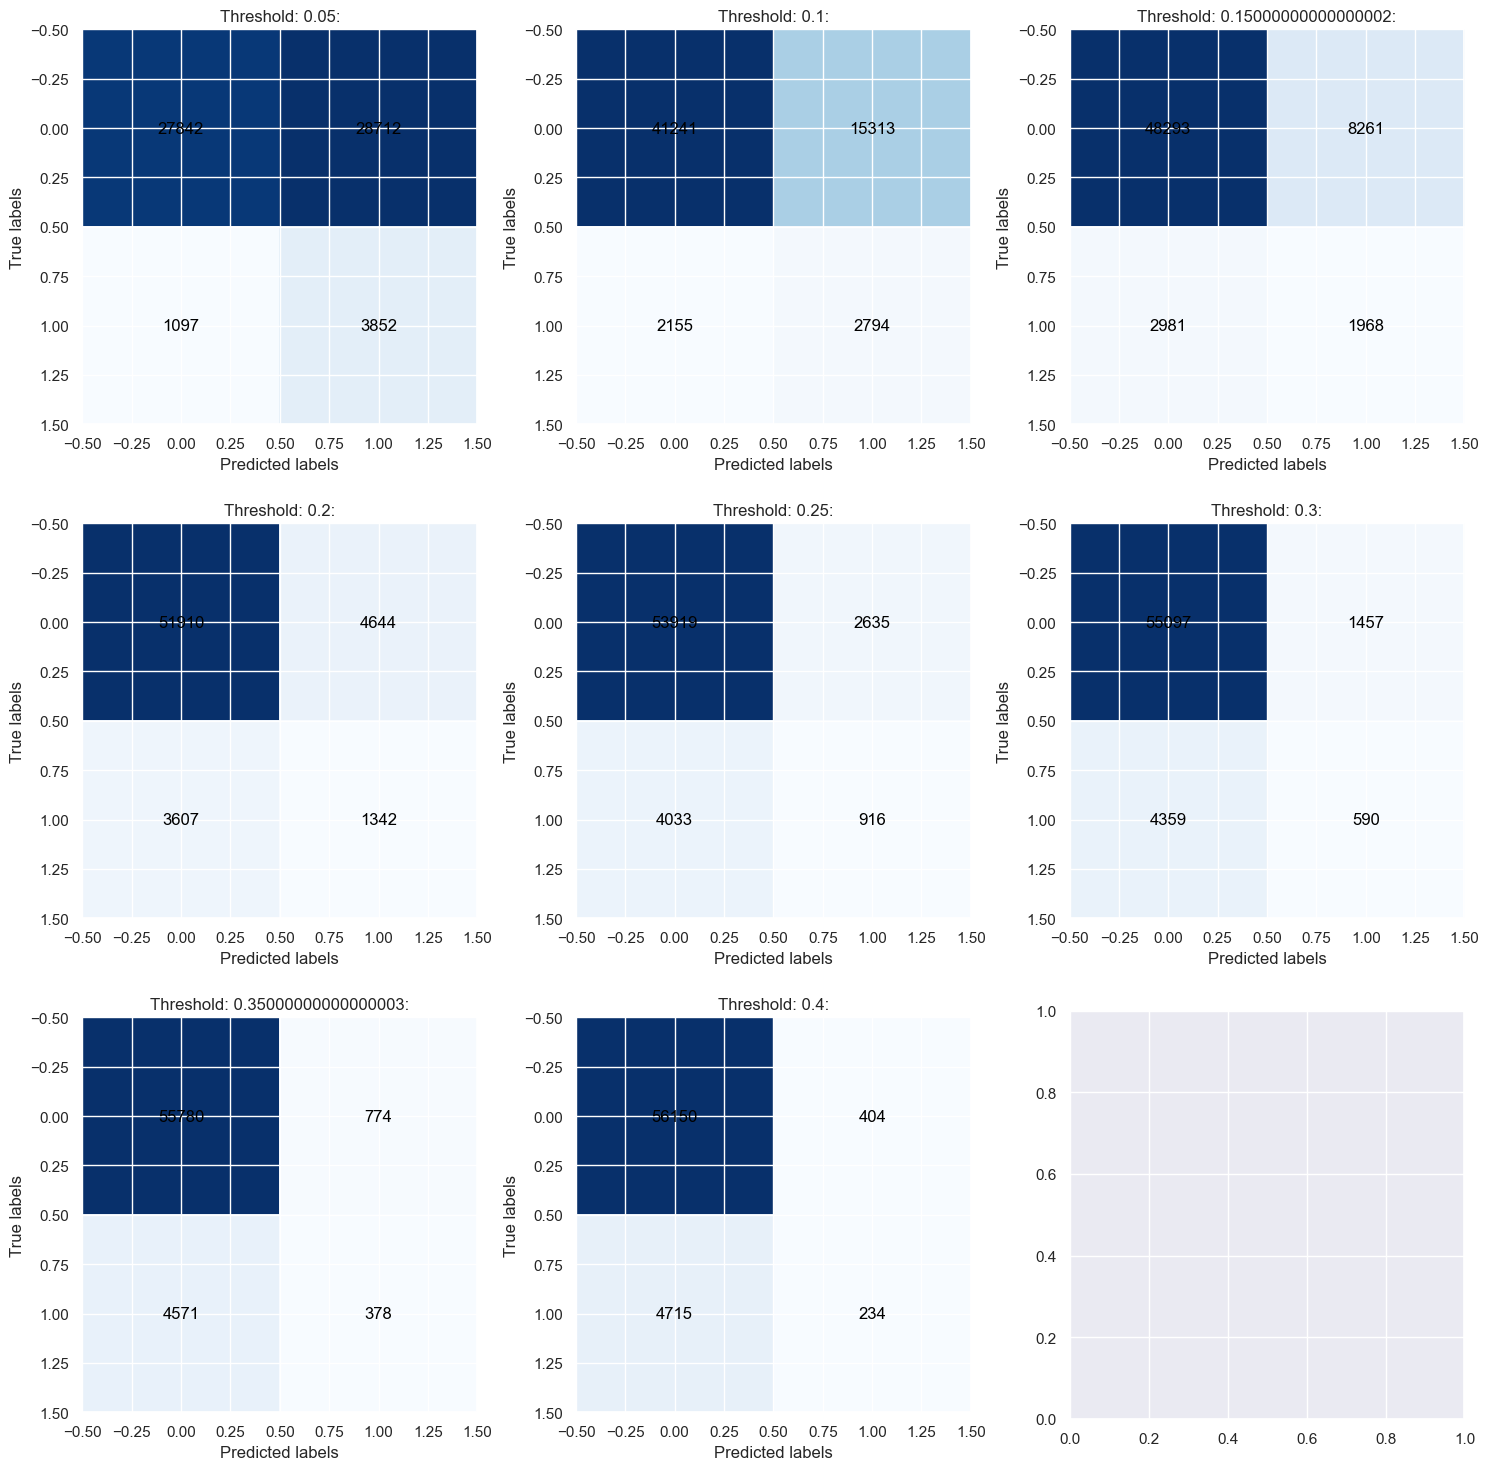

In [32]:
# create subplots for each threshold
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, threshold in enumerate(thresholds):
    row = i // 3
    col = i % 3
    cm = confusion_matrices[i]
    axs[row, col].imshow(cm, cmap='Blues', interpolation='nearest')
    axs[row, col].set_title(f'Threshold: {threshold}:')
    axs[row, col].set_xlabel('Predicted labels')
    axs[row, col].set_ylabel('True labels')
    for i in range(len(cm)):
        for j in range(len(cm)):
            axs[row, col].text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

In [33]:
results_df

,threshold,confusion_matrix,accuracy,recall,precision,F1,TP,FP,TN,FN
0,0.05,"[[27842, 28712], [1097, 3852]]",0.515324,0.778339,0.118290,0.205369,3852,28712,27842,1097
1,0.10,"[[41241, 15313], [2155, 2794]]",0.715981,0.564558,0.154305,0.242366,2794,15313,41241,2155
2,0.15,"[[48293, 8261], [2981, 1968]]",0.817212,0.397656,0.192394,0.259323,1968,8261,48293,2981
3,0.20,"[[51910, 4644], [3607, 1342]]",0.865844,0.271166,0.224190,0.245450,1342,4644,51910,3607
4,0.25,"[[53919, 2635], [4033, 916]]",0.891583,0.185088,0.257956,0.215529,916,2635,53919,4033
5,0.30,"[[55097, 1457], [4359, 590]]",0.905436,0.119216,0.288227,0.168668,590,1457,55097,4359
6,0.35,"[[55780, 774], [4571, 378]]",0.913094,0.076379,0.328125,0.123914,378,774,55780,4571
7,0.40,"[[56150, 404], [4715, 234]]",0.916768,0.047282,0.366771,0.083766,234,404,56150,4715


Based on the data, we chose .1 as a reasonable decision threshold that increases recall and f1 without completely tanking accuracy.

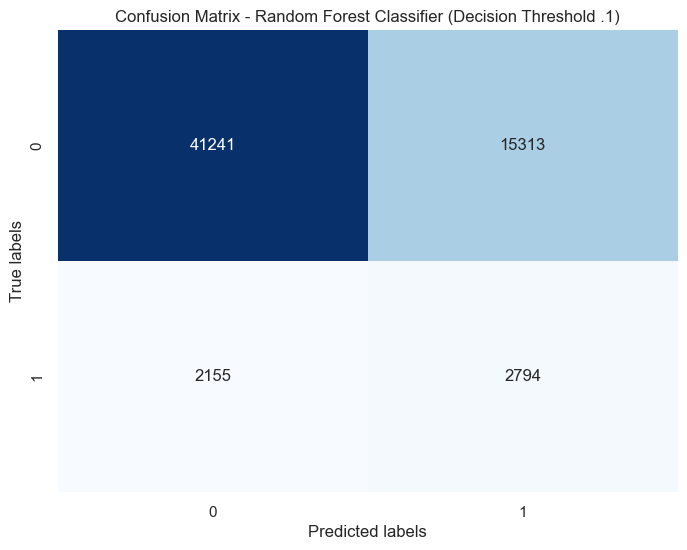

In [41]:
conf_matrix_1 = results_df['confusion_matrix'][1]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest Classifier (Decision Threshold .1)")
plt.show()

In [34]:
# predict with the new decision threshold
threshold = .1
test_pred_prob = test_clf.predict_proba(X_test_pred)[:, 1]
y_pred_test = (test_pred_prob > .1).astype(int)

In [35]:
# find the 1 predicted values
y_pred_true = y_pred_test[y_pred_test == 1]

# find the percentage of predicted 1s
pred_percentage = (len(y_pred_true) / len(y_pred_test)) * 100

In [36]:
print(f'Actual Percentage: {true_percentage}')
print(f'Predicted Percentage: {pred_percentage}')

Actual Percentage: 8.072881945686495
Predicted Percentage: 29.55235516166092


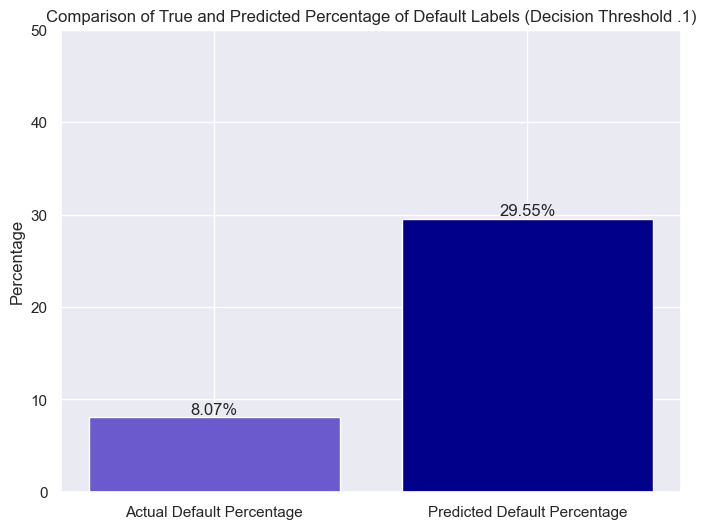

In [37]:
labels = ['Actual Default Percentage', 'Predicted Default Percentage']
values = [true_percentage, pred_percentage]

# plot bars and add labels
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}%', ha='center', va='bottom')

plt.ylabel('Percentage')
plt.title('Comparison of True and Predicted Percentage of Default Labels (Decision Threshold .1)')
plt.ylim(0, 50)
plt.show()


While the rate of positive (default) classifications is now much higher than the actual default percentage, this is preferred because we would much rather have the program incorrectly classify an applicant as high risk than mistakenly let a risky applicant through who later defaults on the loan.

The model does not currently work well. An increase in correlated features may improve it in the future.